## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


## Exploratory Data Analysis


In [211]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import dalex as dx
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, f1_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
import fairlearn.metrics as  fm

In [212]:
df = pd.read_csv(r"C:\Users\pc\Desktop\hackathon ekimetrics\stackoverflow_full.csv")
df

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1
73460,73460,<35,Yes,Undergraduate,1,Man,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,15,1


In [213]:
def create_unique(df):
        
    df_unique = pd.DataFrame(columns=['Column_name','Data_type', 'Number_of_unique','Number_of_missing', 'Unique_values'])

    # loop through the columns in the other dataframe
    for col in df.columns:
        # get the number of unique values in the column
        num_unique = df[col].nunique()

        # add the unique values as a list to the 'Unique_values' column if num_unique <= 5
        if num_unique <= 15:
            unique_vals = list(df[col].unique())
        else:
            unique_vals = "More than 15 unique vales"

        # get the data type of the column
        data_type = df[col].dtype

        # count the number of missing values in the column
        num_missing = df[col].isnull().sum()

        # append a row to the empty dataframe with the column name, number of unique values, unique values, and data type
        df_unique = pd.concat([df_unique, pd.DataFrame([{'Column_name': col, 'Number_of_unique': num_unique, 'Unique_values': unique_vals, 'Data_type':
                                      data_type, 'Number_of_missing': num_missing}])])
    return df_unique

In [214]:
create_unique(df)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values
0,Unnamed: 0,int64,73462,0,More than 15 unique vales
0,Age,object,2,0,"[<35, >35]"
0,Accessibility,object,2,0,"[No, Yes]"
0,EdLevel,object,5,0,"[Master, Undergraduate, PhD, Other, NoHigherEd]"
0,Employment,int64,2,0,"[1, 0]"
0,Gender,object,3,0,"[Man, Woman, NonBinary]"
0,MentalHealth,object,2,0,"[No, Yes]"
0,MainBranch,object,2,0,"[Dev, NotDev]"
0,YearsCode,int64,51,0,More than 15 unique vales
0,YearsCodePro,int64,51,0,More than 15 unique vales


In [215]:
continents = pd.read_excel(r"..\data\countries_continents.xlsx")
df_finale = df.merge(continents, on="Country")
df_finale

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Continent
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,EUR
1,28,>35,No,Undergraduate,1,Man,No,NotDev,10,3,Sweden,40500.0,Bash/Shell;Java;JavaScript;PHP;Python;Ansible;...,8,0,EUR
2,36,<35,No,Master,1,Man,No,Dev,10,7,Sweden,5216.0,Scala;Git;Google Cloud Platform;MongoDB,4,0,EUR
3,156,>35,No,Undergraduate,1,Man,No,Dev,40,26,Sweden,81000.0,Bash/Shell;Dart;HTML/CSS;JavaScript;Python;Doc...,13,0,EUR
4,175,<35,No,PhD,1,Man,No,NotDev,15,3,Sweden,55224.0,C;C++;Java;Matlab;R;Git;Vue.js,7,0,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,48956,>35,No,Other,1,Man,No,Dev,37,31,Timor-Leste,60000.0,C++;Elixir;JavaScript;Python;SQL;Ansible;Docke...,17,0,ASI
73458,46559,>35,No,Master,0,Man,No,Dev,22,20,Mali,50748.0,HTML/CSS;Python;Docker;Kubernetes;FastAPI;Vue....,13,0,AFR
73459,67159,<35,No,Master,1,Man,No,Dev,6,2,Mali,972.0,Dart;JavaScript;Python;Docker;Django;FastAPI;F...,10,0,AFR
73460,67888,>35,No,Master,1,Man,No,Dev,13,9,Mali,14712.0,C;C#;C++;HTML/CSS;Java;JavaScript;PHP;Python;S...,19,1,AFR


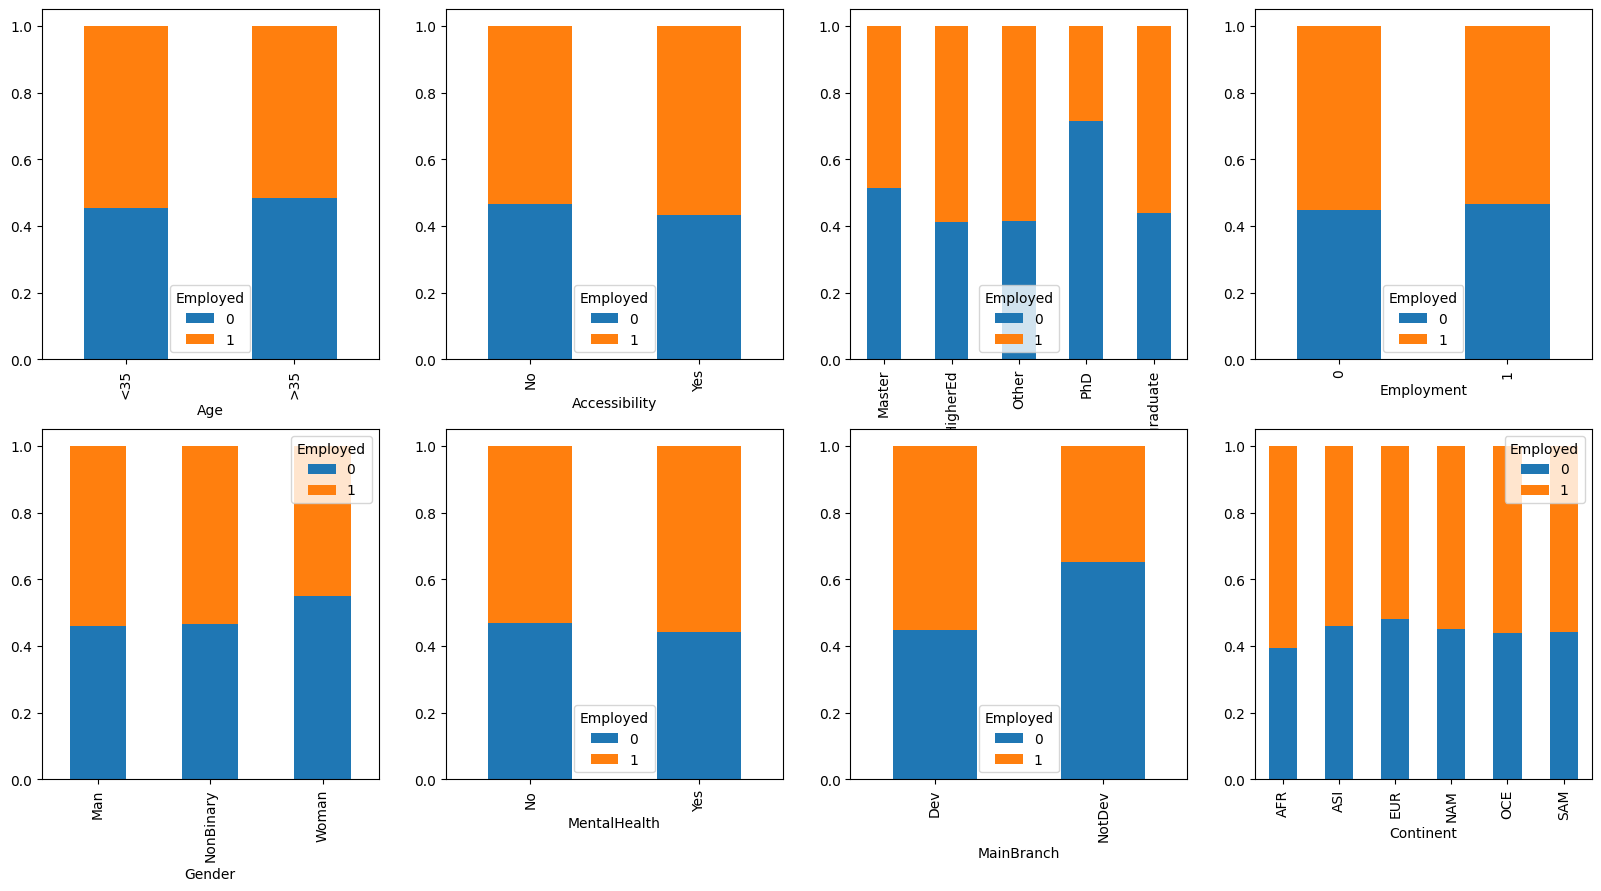

In [216]:
# Présentation de la distribution de "Employed" en fonction des autres variables
variables = ["Age","Accessibility","EdLevel","Employment","Gender","MentalHealth","MainBranch","Continent"]

figure, axis = plt.subplots(nrows=2, ncols=4, figsize=(20, 10)) 
axis = axis.ravel()

i=0
for var in variables:
    probabilities = df_finale.groupby(var)['Employed'].value_counts(normalize=True).unstack()
    ax=axis[i]
    probabilities.plot(kind='bar',stacked=True, ax=ax)
    i+=1


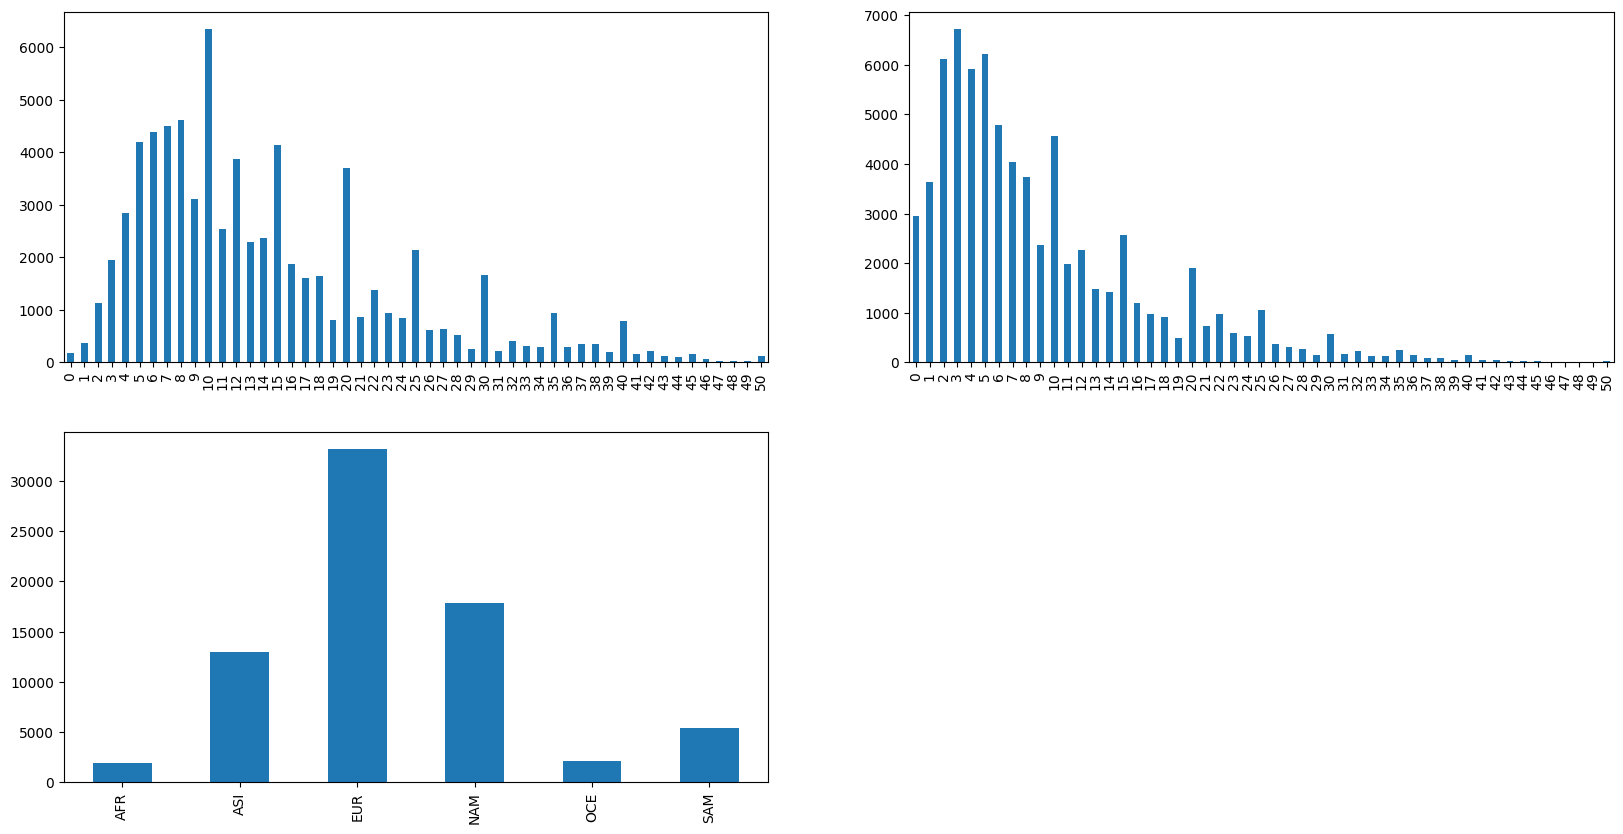

In [217]:
variables = ["YearsCode","YearsCodePro","Continent"]

figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(20, 10)) 
axis = axis.ravel()

i=0
for var in variables:
    counts = df_finale[var].value_counts().sort_index()
    ax=axis[i]
    counts.plot(kind='bar',ax=ax)
    i+=1

figure.delaxes(axis[3])

In [218]:
## Encodage des variables

data= df_finale.loc[:,["Employed","Employment", "YearsCode","YearsCodePro","PreviousSalary", "ComputerSkills"]]

#Age_encoded: égale à 1 si l’age du candidat est <35
data["Age"] = (df_finale["Age"] == ">35").astype(int)

data["Accessibility"] = (df_finale["Accessibility"] == "Yes").astype(int)

data["MentalHealth"] = (df_finale["MentalHealth"] == "Yes").astype(int)

#Gender: on crée deux nouvelles colonnes Woman et NonBinary
data["Woman"] = (df_finale["Gender"]=="Woman").astype(int)
data["NonBinary"] = (df_finale["Gender"]=="NonBinary").astype(int)

# MainBranch: 
data["MainBranch"] = (df_finale["MainBranch"] == "Dev").astype(int)

# EdLevel: 
data["NoHigherEd"] = (df_finale["EdLevel"]=="NoHigherEd").astype(int)
data["Undergraduate"] = (df_finale["EdLevel"]=="Undergraduate").astype(int)
data["Master"] = (df_finale["EdLevel"]=="Master").astype(int)
data["PhD"] = (df_finale["EdLevel"]=="PhD").astype(int)

# Continent
data["AFR"] = (df_finale["Continent"]=="AFR").astype(int)
data["SAM"] = (df_finale["Continent"]=="SAM").astype(int)
data["ASI"] = (df_finale["Continent"]=="ASI").astype(int)
data["EUR"] = (df_finale["Continent"]=="EUR").astype(int)
data["NAM"] = (df_finale["Continent"]=="NAM").astype(int)

data

,Employed,Employment,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Age,Accessibility,MentalHealth,Woman,...,MainBranch,NoHigherEd,Undergraduate,Master,PhD,AFR,SAM,ASI,EUR,NAM
0,0,1,7,4,51552.0,4,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,0,1,10,3,40500.0,8,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,1,10,7,5216.0,4,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,0,1,40,26,81000.0,13,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,0,1,15,3,55224.0,7,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,0,1,37,31,60000.0,17,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
73458,0,0,22,20,50748.0,13,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
73459,0,1,6,2,972.0,10,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
73460,1,1,13,9,14712.0,19,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0


## Modeling

Pour la modélisation, nous allons utiliser dans un premier temps la régression logistique, on évaluera ce modèle avec les paramètres suivants:

- **Accuracy**: c’est le nombre de prédictions correctes divisé par le nombre d’observations.
- **Recall**: c’est le nombre de positifs bien prédits (Vrai Positif) divisé par l’ensemble des positifs (Vrai Positif + Faux Positif).
- **Precision**: c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédits (Vrai Positif + Faux Positif).
- **Confusion matrix**: c’est une matrice 2x2 qui contients les nombres suivants: (1,1):vrais négatifs , (1,2):faux positifs , (2,1):faux negatifs, (2,2):vrais positifs
- **F1 Score**: la moyenne harmonique de la précision et le recall.
- **ROC AUC**: 

In [219]:
# Table contenant les performances de chaque modèle
metrics = pd.DataFrame(columns=["Modèle", "Accuracy_test","Accuracy_train","Recall_test","Recall_train","Precision_test","Precision_train","Confusion Matrix_test", "Confusion Matrix_train","F1 Score_test", "F1 Score_train","ROC AUC_test","ROC AUC_train","demographic_parity_test","demographic_parity_train", "equalized_odds_test","equalized_odds_train","Cross_validation_mean"])


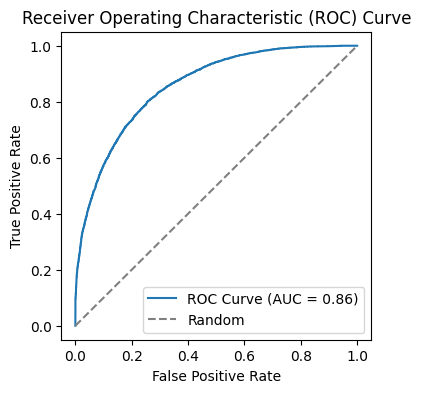

In [220]:
# Utilisation de la régression logistique
X = data.iloc[:,1:]
y = data["Employed"]
sens_features = ["Age","Woman","NonBinary"]
# "MentalHealth","Accessibility","Employment", "AFR","SAM","ASI","EUR","NAM"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#instantiate the model
log_regression = LogisticRegression(solver= "liblinear")

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_pred_test = log_regression.predict(X_test)

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)

# Recall
recall_test = recall_score(y_test, y_pred_test)

#Precision
precision_test = precision_score(y_test, y_pred_test)

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)

# ROC AUC
y_pred_prob_test = log_regression.predict_proba(X_test)
roc_auc_test= roc_auc_score(y_test, y_pred_prob_test[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# Paramètres de disparité
demographic_parity_test = fm.demographic_parity_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])
equalized_odds_test = fm.equalized_odds_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#use model to make predictions on train data
y_pred_train = log_regression.predict(X_train)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)

# Recall
recall_train = recall_score(y_train, y_pred_train)

#Precision
precision_train = precision_score(y_train, y_pred_train)

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_train = f1_score(y_train, y_pred_train)

# ROC AUC
y_pred_prob_train = log_regression.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# La validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser cross_val_score pour obtenir les scores de validation croisée moyenne
cross_val_scores = cross_val_score(log_regression, X, y, cv=kf)

# Afficher la moyenne des scores
cross_val_mean = cross_val_scores.mean()

demographic_parity_train = fm.demographic_parity_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])
equalized_odds_train = fm.equalized_odds_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])

metrics = pd.concat([metrics, pd.DataFrame([{"Modèle": "RegLog sans pénalisation", "Accuracy_train": accuracy_train,"Recall_train": recall_train,"Precision_train": precision_train,"Confusion Matrix_train": conf_matrix_train, "F1 Score_train": f1_train, "demographic_parity_train":demographic_parity_train,
                                             "demographic_parity_test" :demographic_parity_test, "ROC AUC_train": roc_auc_train, "Accuracy_test": accuracy_test,"Recall_test": recall_test,"Precision_test": precision_test,"Confusion Matrix_test": conf_matrix_test, "F1 Score_test": f1_test,"ROC AUC_test": roc_auc_test, 
                                             "equalized_odds_train": equalized_odds_train, "equalized_odds_test" : equalized_odds_test, "Cross_validation_mean": cross_val_mean}])])

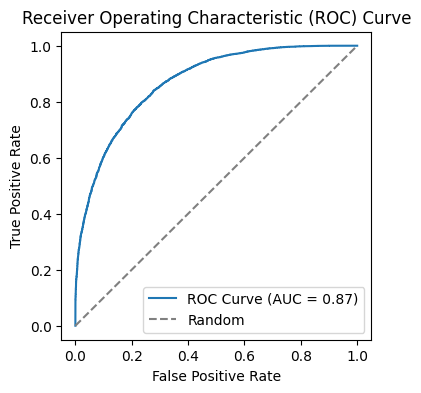

In [221]:
#instantiate the model
log_regression1 = LogisticRegression(penalty="l1", solver="liblinear")

#fit the model using the training data
log_regression1.fit(X_train,y_train)

#use model to make predictions on test data
y_pred_test = log_regression1.predict(X_test)

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)

# Recall
recall_test = recall_score(y_test, y_pred_test)

#Precision
precision_test = precision_score(y_test, y_pred_test)

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)

# ROC AUC
y_pred_prob_test = log_regression1.predict_proba(X_test)
roc_auc_test= roc_auc_score(y_test, y_pred_prob_test[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# Paramètres de disparité
demographic_parity_test = fm.demographic_parity_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])
equalized_odds_test = fm.equalized_odds_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#use model to make predictions on train data
y_pred_train = log_regression1.predict(X_train)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)

# Recall
recall_train = recall_score(y_train, y_pred_train)

#Precision
precision_train = precision_score(y_train, y_pred_train)

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_train = f1_score(y_train, y_pred_train)

# ROC AUC
y_pred_prob_train = log_regression1.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# La validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser cross_val_score pour obtenir les scores de validation croisée moyenne
cross_val_scores = cross_val_score(log_regression1, X, y, cv=kf)

# Afficher la moyenne des scores
cross_val_mean = cross_val_scores.mean()

demographic_parity_train = fm.demographic_parity_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])
equalized_odds_train = fm.equalized_odds_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])

metrics = pd.concat([metrics, pd.DataFrame([{"Modèle": "RegLog avec pénalisation", "Accuracy_train": accuracy_train,"Recall_train": recall_train,"Precision_train": precision_train,"Confusion Matrix_train": conf_matrix_train, "F1 Score_train": f1_train, "demographic_parity_train":demographic_parity_train,
                                             "demographic_parity_test" :demographic_parity_test, "ROC AUC_train": roc_auc_train, "Accuracy_test": accuracy_test,"Recall_test": recall_test,"Precision_test": precision_test,"Confusion Matrix_test": conf_matrix_test, "F1 Score_test": f1_test,"ROC AUC_test": roc_auc_test, 
                                             "equalized_odds_train": equalized_odds_train, "equalized_odds_test" : equalized_odds_test, "Cross_validation_mean": cross_val_mean}])])

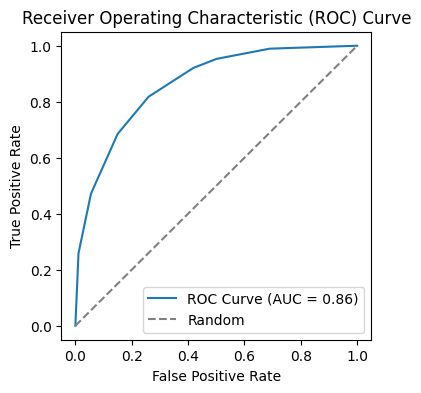

In [222]:
# Modèle d’arbre binaire
tree = DecisionTreeClassifier(max_depth=3 ,random_state=42)
tree.fit(X_train,y_train)

#use model to make predictions on test data
y_pred_test = tree.predict(X_test)

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)

# Recall
recall_test = recall_score(y_test, y_pred_test)

#Precision
precision_test = precision_score(y_test, y_pred_test)

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)

# ROC AUC
y_pred_prob_test = tree.predict_proba(X_test)
roc_auc_test= roc_auc_score(y_test, y_pred_prob_test[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# Paramètres de disparité
demographic_parity_test = fm.demographic_parity_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])
equalized_odds_test = fm.equalized_odds_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#use model to make predictions on train data
y_pred_train = tree.predict(X_train)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)

# Recall
recall_train = recall_score(y_train, y_pred_train)

#Precision
precision_train = precision_score(y_train, y_pred_train)

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_train = f1_score(y_train, y_pred_train)

# ROC AUC
y_pred_prob_train = tree.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# La validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser cross_val_score pour obtenir les scores de validation croisée moyenne
cross_val_scores = cross_val_score(tree, X, y, cv=kf)

# Afficher la moyenne des scores
cross_val_mean = cross_val_scores.mean()

demographic_parity_train = fm.demographic_parity_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])
equalized_odds_train = fm.equalized_odds_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])

metrics = pd.concat([metrics, pd.DataFrame([{"Modèle": "DecisionTree de profondeur 3", "Accuracy_train": accuracy_train,"Recall_train": recall_train,"Precision_train": precision_train,"Confusion Matrix_train": conf_matrix_train, "F1 Score_train": f1_train, "demographic_parity_train":demographic_parity_train,
                                             "demographic_parity_test" :demographic_parity_test, "ROC AUC_train": roc_auc_train, "Accuracy_test": accuracy_test,"Recall_test": recall_test,"Precision_test": precision_test,"Confusion Matrix_test": conf_matrix_test, "F1 Score_test": f1_test,"ROC AUC_test": roc_auc_test, 
                                             "equalized_odds_train": equalized_odds_train, "equalized_odds_test" : equalized_odds_test, "Cross_validation_mean": cross_val_mean}])])

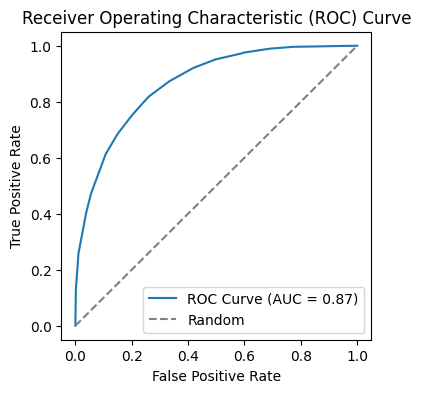

In [223]:
# Modèle d’arbre binaire
tree1 = DecisionTreeClassifier(max_depth=4 ,random_state=42)
tree1.fit(X_train,y_train)

#use model to make predictions on test data
y_pred_test = tree1.predict(X_test)

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)

# Recall
recall_test = recall_score(y_test, y_pred_test)

#Precision
precision_test = precision_score(y_test, y_pred_test)

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)

# ROC AUC
y_pred_prob_test = tree1.predict_proba(X_test)
roc_auc_test= roc_auc_score(y_test, y_pred_prob_test[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# Paramètres de disparité
demographic_parity_test = fm.demographic_parity_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])
equalized_odds_test = fm.equalized_odds_ratio(y_test, y_pred_test, sensitive_features=X_test.loc[:,sens_features])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#use model to make predictions on train data
y_pred_train = tree1.predict(X_train)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)

# Recall
recall_train = recall_score(y_train, y_pred_train)

#Precision
precision_train = precision_score(y_train, y_pred_train)

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_train = f1_score(y_train, y_pred_train)

# ROC AUC
y_pred_prob_train = tree1.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train[:, 1])  # y_pred_prob est la probabilité prédite pour chaque classe

# La validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser cross_val_score pour obtenir les scores de validation croisée moyenne
cross_val_scores = cross_val_score(tree1, X, y, cv=kf)

# Afficher la moyenne des scores
cross_val_mean = cross_val_scores.mean()

demographic_parity_train = fm.demographic_parity_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])
equalized_odds_train = fm.equalized_odds_ratio(y_train, y_pred_train, sensitive_features=X_train.loc[:,sens_features])

metrics = pd.concat([metrics, pd.DataFrame([{"Modèle": "DecisionTree de profondeur 4", "Accuracy_train": accuracy_train,"Recall_train": recall_train,"Precision_train": precision_train,"Confusion Matrix_train": conf_matrix_train, "F1 Score_train": f1_train, "demographic_parity_train":demographic_parity_train,
                                             "demographic_parity_test" :demographic_parity_test, "ROC AUC_train": roc_auc_train, "Accuracy_test": accuracy_test,"Recall_test": recall_test,"Precision_test": precision_test,"Confusion Matrix_test": conf_matrix_test, "F1 Score_test": f1_test,"ROC AUC_test": roc_auc_test, 
                                             "equalized_odds_train": equalized_odds_train, "equalized_odds_test" : equalized_odds_test, "Cross_validation_mean": cross_val_mean}])])

In [224]:
metrics

,Modèle,Accuracy_test,Accuracy_train,Recall_test,Recall_train,Precision_test,Precision_train,Confusion Matrix_test,Confusion Matrix_train,F1 Score_test,F1 Score_train,ROC AUC_test,ROC AUC_train,demographic_parity_test,demographic_parity_train,equalized_odds_test,equalized_odds_train,Cross_validation_mean
0,RegLog sans pénalisation,0.771456,0.774983,0.790150,0.797710,0.784163,0.786094,"[[5126, 1709], [1649, 6209]]","[[20390, 6845], [6379, 25155]]",0.787145,0.791859,0.857060,0.861347,0.664603,0.605437,0.343109,0.527176,0.774196
0,RegLog avec pénalisation,0.780984,0.785482,0.788623,0.797964,0.799200,0.801395,"[[5278, 1557], [1661, 6197]]","[[20999, 6236], [6371, 25163]]",0.793877,0.799676,0.870305,0.873471,0.672434,0.637953,0.399386,0.526562,0.783779
0,DecisionTree de profondeur 3,0.781733,0.784870,0.817765,0.825680,0.783563,0.784649,"[[5060, 1775], [1432, 6426]]","[[20089, 7146], [5497, 26037]]",0.800299,0.804642,0.862011,0.865526,0.672699,0.662042,0.437588,0.592198,0.784242
0,DecisionTree de profondeur 4,0.781733,0.784870,0.817765,0.825680,0.783563,0.784649,"[[5060, 1775], [1432, 6426]]","[[20089, 7146], [5497, 26037]]",0.800299,0.804642,0.865614,0.869498,0.672699,0.662042,0.437588,0.592198,0.783752


## Fairness performance

To facilitate the development of a responsible model, we use the dalex python package: https://dalex.drwhy.ai/


Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

##### Metrics used

Description of the metrics used for the fairness performance evaluation of each strategys:



- **Equal opportunity ratio** computed from True positive rate (recall)

> This number describes the proportions of correctly classified positive instances.

> $TPR = \frac{TP}{P}$

- **Predictive parity ratio** computed from Positive predicted value (precision)

> This number describes the ratio of samples which were correctly classified as positive from all the positive predictions.

> $PPV = \frac{TP}{TP + FP}$

- **Accuracy equality ratio** computed from Accuracy

> This number is the ratio of the correctly classified instances (positive and negative) of all decisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Predictive equality ratio** computed from False positive rate

> This number describes the share the proportion of actual negatives which was falsely classified as positive.

> $FPR = \frac{FP}{TP + TN}$

- **Statistical parity ratio** computed from Positive rate

> This number is the overall rate of positively classified instances, including both correct and incorrect decisions.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.